# Creating the Huacos Data Set from Google Images

The next few lines follow the instructions from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb and collect images from Google for the categories of Huacos that we are interested in. The Google search terms used were:

* mochica ceramics
* chimu ceramics
* chavin ceramics
* nazca ceramics
* paracas ceramics
* inca ceramics
* tiahuanaco ceramics

**NB** A quick visual inspection of the images shows a couple of problems: first that not all of the images returned are actual photographs (despite the fact that we asked Google to only search for photographs) and two that several of the images appeared in different searches, i.e. a the same 'huaco' appeared to be labeled as both Inca and Nazca. Some manual cleaning of the database will be needed to deal with this problem as it could affect the accuracy of the results. 

In [1]:
from fastai.vision import *

## Create Directories for the data

Note that the `csv` files have to be inside the `data\huacos` directory

In [60]:
folder = 'mochica'
file = 'urls_mochica.csv'

In [36]:
folder = 'chimu'
file = 'urls_chimu.csv'

In [38]:
folder = 'chavin'
file = 'urls_chavin.csv'

In [40]:
folder = 'nazca'
file = 'urls_nazca.csv'

In [42]:
folder = 'paracas'
file = 'urls_paracas.csv'

In [44]:
folder = 'inca'
file = 'urls_inca.csv'

In [46]:
folder = 'tiahuanaco'
file = 'urls_tiahuanaco.csv'

The following lines create the data folders, note that the line below has to be run multiple times. First run one of the lines above for each category and then run the lines below.

In [74]:
path = Path('data/huacos')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [62]:
path.ls()

[PosixPath('data/huacos/inca'),
 PosixPath('data/huacos/paracas'),
 PosixPath('data/huacos/.DS_Store'),
 PosixPath('data/huacos/urls_inca.csv'),
 PosixPath('data/huacos/urls_mochica.csv'),
 PosixPath('data/huacos/nazca'),
 PosixPath('data/huacos/urls_tiahuanaco.csv'),
 PosixPath('data/huacos/urls_paracas.csv'),
 PosixPath('data/huacos/chimu'),
 PosixPath('data/huacos/mochica'),
 PosixPath('data/huacos/chavin'),
 PosixPath('data/huacos/urls_nazca.csv'),
 PosixPath('data/huacos/tiahuanaco'),
 PosixPath('data/huacos/urls_chavin.csv'),
 PosixPath('data/huacos/urls_chimu.csv')]

In [63]:
classes = ['inca', 'paracas', 'nazca', 'chimu', 'mochina', 'chavin', 'tiahuanaco']

## Donwload the images
The next line of code has to be run once for each category. Set up the values using the cells in earlier parts of this notebook

In [78]:
folder = 'mochica'
file = 'urls_mochica.csv'
dest = path/folder

print(file)
print(dest)

urls_mochica.csv
data/huacos/mochica


In [79]:
download_images(path/file, dest, max_pics=400)

In [81]:
folder = 'chimu'
file = 'urls_chimu.csv'
dest = path/folder
print(dest)

data/huacos/chimu


In [82]:
download_images(path/file, dest, max_pics=400)

In [83]:
folder = 'chavin'
file = 'urls_chavin.csv'
dest = path/folder
print(dest)
download_images(path/file, dest, max_pics=400)

data/huacos/chavin


In [84]:
folder = 'inca'
file = 'urls_inca.csv'
dest = path/folder
print(dest)
download_images(path/file, dest, max_pics=400)

data/huacos/inca


In [85]:
folder = 'paracas'
file = 'urls_chimu.csv'
dest = path/folder
print(dest)
download_images(path/file, dest, max_pics=400)

data/huacos/paracas


In [86]:
folder = 'nazca'
file = 'urls_nazca.csv'
dest = path/folder
print(dest)
download_images(path/file, dest, max_pics=400)

data/huacos/nazca
Error https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTr1uIe_PpSCvoChigaEI-DDK-AybH7B2jaHP2myAFaPwyiWCiY HTTPSConnectionPool(host='encrypted-tbn0.gstatic.com', port=443): Max retries exceeded with url: /images?q=tbn%3AANd9GcTr1uIe_PpSCvoChigaEI-DDK-AybH7B2jaHP2myAFaPwyiWCiY (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x102eccee10>, 'Connection to encrypted-tbn0.gstatic.com timed out. (connect timeout=4)'))


In [87]:
folder = 'tiahuanaco'
file = 'urls_tiahuanaco.csv'
dest = path/folder
print(dest)
download_images(path/file, dest, max_pics=400)

data/huacos/tiahuanaco


## Look at the Data

In [88]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [89]:
data.classes

['chavin', 'chimu', 'inca', 'mochica', 'nazca', 'paracas', 'tiahuanaco']

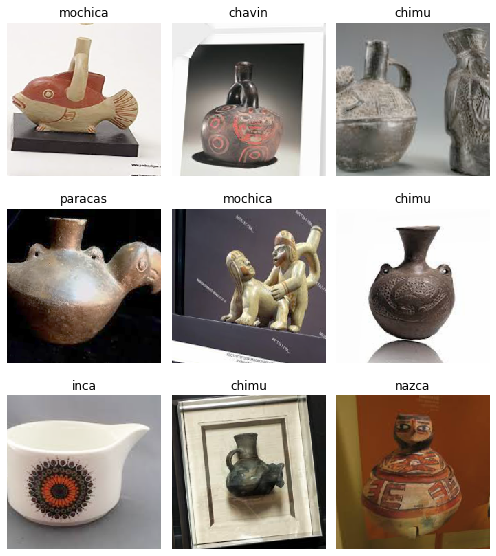

In [90]:
data.show_batch(rows=3, figsize=(7,8))

Some statistics about the data set. Show the classes, the number of classes lenght of the training and validation sets

In [91]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['chavin', 'chimu', 'inca', 'mochica', 'nazca', 'paracas', 'tiahuanaco'],
 7,
 2240,
 559)

## Cleaning up the data

As I mentioned earlier, the data that was collected contains images that should not be in the dataset or that should not be in a particular dataset. These 'rogue' images will impact the accuracy and performance of the model. So we are going to clean the data set using the ImageCleaner widget from fastai.widgets . With this widget we can prune our top losses, removing photos that don't belong

In [92]:
from fastai.widgets import *